In [ ]:
# |default_exp conv

In [2]:
import miniai.datasets as ds
import miniai.training as tr

# Convolutions

Allow us to tell our network something about the structure of the problem that might make it easier to solve.

For images, images are layed out on a 2D BW/ 3D color grid. There are generally relationships between close pixels, relationships across dimensions, similar pixel often represent similar things etc.

Images have features, distinct attributes.

## Data

In [3]:
# Download the MNIST dataset
import gzip
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
from pathlib import Path
from urllib.request import urlretrieve

MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"

data_path = Path("data/mnist")
data_path.mkdir(exist_ok=True)
gz_path = data_path / "mnist.pkl.gz"

mpl.rcParams["image.cmap"] = "gray"

if not gz_path.exists():
    urlretrieve(MNIST_URL, gz_path)

# File contains a tuple of tuples for the x and y, train and validation data
# Images are 28x28
with gzip.open(gz_path, "rb") as file:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(file, encoding="latin-1")

# Put into tensors
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Convolution equations

See [CNNs from different viewpoints](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c).

Convolutions have an input (think of it as a grid) and a kernel (think of it as another grid, and as a filter).

Eg a 3x3 input:

```
ABC
DEF
GHJ
```

and a 2x2 kernel:

```
jk
lm
```

with an output:

```
PQ
RS
```

We slide the kernel along the input, putting the result in the top left of the output..

```
P = j*A + k*B + l*D + m*E + bias
```

then we "slide along one"

```
Q = j*B + k*C + l*E + m*F + bias
```

and so on for the next row of output:

```
R = j*D + k*E + l*G + m*H  + bias
S = j*E + k*F + l*H + m*J  + bias
```

<Axes: >

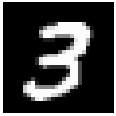

In [4]:
# Lets try and do one on one of the images, lets pick this 3

x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

mpl.rcParams["figure.dpi"] = 30

im3 = x_imgs[7]
ds.show_image(im3)

<Axes: >

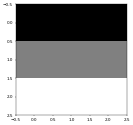

In [6]:
# Here is a kernel that trys to detect top edges
top_edge = tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]).float()

## It can be visualised like this
ds.show_image(top_edge, noframe=False)

What happens when we run this filter?

If we have an input of

```
a1 a2 a3
a4 a5 a6
a7 a8 a9
```

we would get

```
-a1 -a2  -a3 + a7 + a8 + a9
```

why does this matter? Consider just a section of our 3.

In [14]:
import pandas as pd

df = pd.DataFrame(im3[:13, :23])
df.style.format(precision=2).set_properties(**{"font-size": "7pt"}).background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [22]:
# What if we take a section of the image at the top of an edge
print(im3[3:6, 14:17])

# And apply our kernel
(im3[3:6, 14:17] * top_edge).sum()

# We get a large positive value, the three negatives in our kernel are all 0s, and the 1's are all large positives

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.9961, 0.9883, 0.9883]])


tensor(2.9727)

In [28]:
# What if we look a the bottom of an edge
print(im3[7:10, 14:17])

# And apply our kernel
(im3[7:10, 14:17] * top_edge).sum()

# We get a large negative as now our negatives have large values and our positives are zero

tensor([[0.9883, 0.9844, 0.9844],
        [0.5195, 0.5156, 0.5156],
        [0.0000, 0.0000, 0.0000]])


tensor(-2.9570)

In [31]:
# We can put this in a function
# row,col specifis the center of the input
def apply_kernel(row, col, kernel):
    return (im3[row - 1 : row + 2, col - 1 : col + 2] * kernel).sum()


apply_kernel(4, 15, top_edge)

tensor(2.9727)

<Axes: >

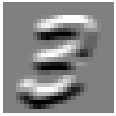

In [37]:
# Lets apply it to all of them
img3_edges = tensor([[apply_kernel(i, j, top_edge) for j in range(1, 27)] for i in range(1, 27)])

# Note the top edges are highlighted
ds.show_image(img3_edges)

<Axes: >

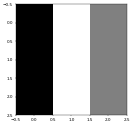

In [40]:
# We can do this for other edges
left_edge = tensor([[-1, 1, 0], [-1, 1, 0], [-1, 1, 0]])

ds.show_image(left_edge, noframe=False)

<Axes: >

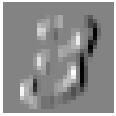

In [41]:
# And apply the left edge kernel
img3_edges = tensor([[apply_kernel(i, j, left_edge) for j in range(1, 27)] for i in range(1, 27)])

# Note the top edges are highlighted
ds.show_image(img3_edges)

Notice that we always lose the outer edge of our image.